In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
 
import gc
import os
import ast
import sys
import configparser
import glob
import librosa
import librosa.display
from scipy.stats import mode

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import keras
from keras import backend as K

## (1) Load songs and transfrom them into MEL-Spectrogram

In [26]:
def load_songs(song_folder):
    song_specs = []
    idx_to_genre = []
    genre_to_idx = {}
    genres = []    
    for genre in os.listdir(song_folder):
        genre_to_idx[genre] = len(genre_to_idx)
        idx_to_genre.append(genre)
        genre_folder = os.path.join(song_folder, genre)
        for song in os.listdir(genre_folder):
            if song.endswith('.wav'):
                signal, sr = librosa.load(os.path.join(genre_folder, song))
                melspec = librosa.feature.melspectrogram(signal, sr=sr).T[:1280,]
                song_specs.append(melspec)
                genres.append(genre_to_idx[genre])
                
    return song_specs, genres, genre_to_idx, idx_to_genre

song_specs, genres, genre_to_idx, idx_to_genre = load_songs('C:/Users/wanke/Study_sound/proj02_Sound/speech_transformation/song_folder/genres')


In [27]:
len(song_specs)

200

In [42]:
genres[79]

3

In [40]:
genre_to_idx

{'CSBae': 0,
 'CWKim': 1,
 'EHSoh': 2,
 'JPark': 3,
 'KHChoi': 4,
 'SHAkmu': 5,
 'SHPark': 6,
 'SJBae': 7,
 'SYKim': 8,
 'YHCho': 9}

In [54]:
idx_to_genre[3]

'JPark'

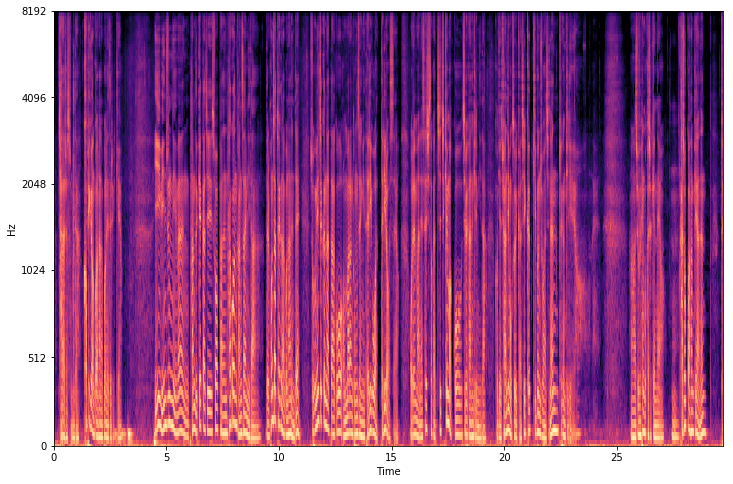

In [53]:
librosa.display.specshow(librosa.power_to_db(song_specs[79].T,
                                              ref=np.max),
                          y_axis='mel', fmax=8192,
                          x_axis='time')

In [55]:
def show_spectogram(show_genre):
    '''
    genre 이름을 넣으면 genre에 해당하는 spectogram을 볼 수 있음 
    :param show_genre: 사용자가 보려는 장르의 이름 
    :return: 
    '''
    show_genre = genre_to_idx[show_genre]
    # genre_to_idx dictionary를 통해 genre에 해당하는 index 얻기
    specs = []
    for spec, genre in zip(song_specs, genres):
        # song 의 melspec 정보를 가진 리스트인 song_specs와 genre 정보를 가진 리스트인 genres를 zip 한다
        # 그럼으로써 iteration을 돌 때 spec, genre에 각각 song 정보와 genre 정보가 assign 된다.
        
        if show_genre == genre:
            # song_specs, genres에는 모든 song에 대한 정보가 담겨 있으므로
            # 사용자가 보려는 장르만 보기 위해 if 문 사용
            specs.append(spec)
            # 장르에 해당하는 melspec 값을 리스트에 할당
            if len(specs) == 20:
                break
            # 리스트의 길이가 25개 일경우 for문 빠져나가기
    if not specs:
        # 사용자가 보고 싶어하는 장르가 song에 존재하지 않으면 specs이 비어 있을 테고,
        # 해당 장르를 찾지 못했으므로 not found 반환
        return 'not found!'
    x = np.concatenate(specs, axis=1)
    # specs내에 위치한 값들을 axis=1 축으로 이어 붙인다.
    x = (x - x.min()) / (x.max() - x.min())
    # normalisation
    plt.imshow((x * 20).clip(0, 1.0))
    # normalisation

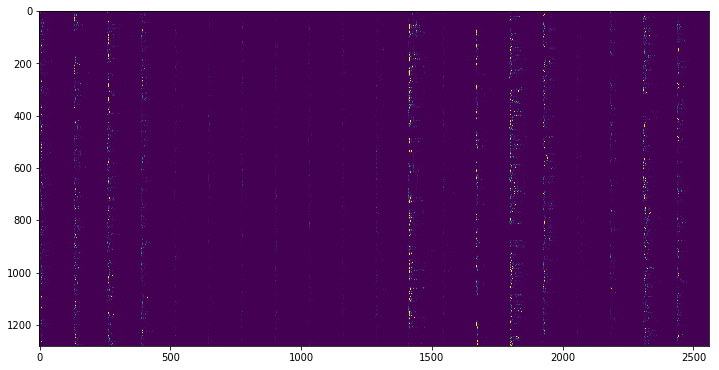

In [56]:
show_spectogram('SYKim')

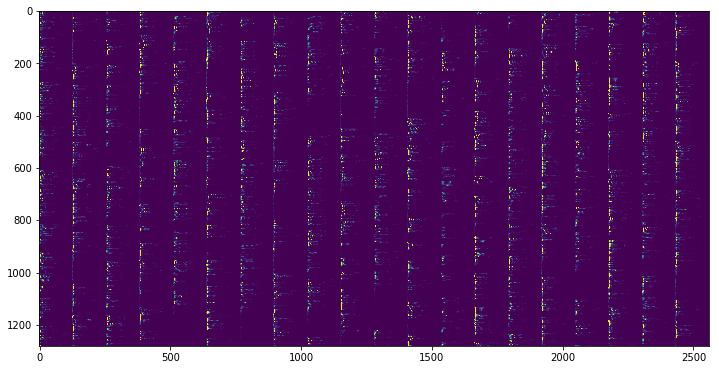

In [57]:
show_spectogram('JPark')

In [58]:
def lstm_model(input_shape):
    inputs = Input(shape=input_shape, name='input')
    lstm_1 = LSTM(units=128, return_sequences=False)(inputs)
    
    dense2 = Dense(10, activation='softmax')(lstm_1)

    model = Model(inputs=[inputs], outputs=[dense2])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def cnn_model(input_shape):
    inputs = Input(input_shape)
    x = inputs
    levels = 64
    
    for level in range(3):
        x = Conv1D(levels, 3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(pool_size=2, strides=2)(x)
        levels *= 2
    
    # Global Layers
    x = GlobalMaxPooling1D()(x)

    for fc in range(2):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    labels = Dense(10, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[labels])
    sgd = keras.optimizers.SGD(lr=0.0003, momentum=0.9, decay=1e-5, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

model = cnn_model((128, 128))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 126, 64)           24640     
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 64)           256       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 63, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 61, 128)           24704     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 128)           512       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 30, 128)           0         
__________

In [59]:
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)


genres_one_hot = keras.utils.to_categorical(genres, num_classes=len(genre_to_idx))

x_train, x_test, y_train, y_test = train_test_split(
    np.array(song_specs), np.array(genres_one_hot), 
    test_size=0.1, stratify=genres)

x_train.shape, y_train.shape

((180, 1280, 128), (180, 10))

In [71]:
x_train[1], y_train[170]

(array([[5.43679888e-06, 2.91205724e-05, 6.84704385e-05, ...,
         1.43122283e-06, 6.96961146e-07, 6.43540326e-08],
        [2.56266242e-04, 4.78924227e-04, 6.16031827e-03, ...,
         4.95212050e-06, 2.23220693e-06, 5.21405672e-08],
        [5.83332875e-03, 1.90970760e-02, 2.78824988e-02, ...,
         3.51907692e-06, 1.17755362e-06, 3.48372259e-08],
        ...,
        [9.05972149e-04, 1.14590808e-03, 1.93943370e-03, ...,
         2.34611489e-05, 7.60947245e-06, 2.20747264e-07],
        [2.28553361e-04, 1.19597246e-03, 2.88756733e-03, ...,
         6.88243132e-05, 3.11649542e-05, 9.59272809e-07],
        [4.42331007e-04, 5.18380111e-04, 3.68767183e-03, ...,
         5.43676721e-04, 2.62181717e-04, 9.67459283e-06]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [72]:
x_test, y_test = split_10(x_test, y_test)
x_train, y_train = split_10(x_train, y_train)

x_train.shape, y_train.shape

((1800, 128, 128), (1800, 10))

In [74]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
      min_delta=0,
      patience=3,
      verbose=0,
      mode='auto')

    # Fit the model
history = model.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])

Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 4s 2ms/step - loss: 3.0097 - acc: 0.1628 - val_loss: 1.8192 - val_acc: 0.3800
Epoch 2/100
1800/1800 [==============================] - 4s 2ms/step - loss: 2.6636 - acc: 0.1917 - val_loss: 1.7150 - val_acc: 0.5000
Epoch 3/100
1800/1800 [==============================] - 5s 3ms/step - loss: 2.5138 - acc: 0.2289 - val_loss: 1.6443 - val_acc: 0.5350
Epoch 4/100
1800/1800 [==============================] - 4s 2ms/step - loss: 2.3377 - acc: 0.2389 - val_loss: 1.6144 - val_acc: 0.5250
Epoch 5/100
1800/1800 [==============================] - 5s 3ms/step - loss: 2.1599 - acc: 0.2694 - val_loss: 1.5826 - val_acc: 0.5350
Epoch 6/100
1800/1800 [==============================] - 4s 2ms/step - loss: 2.1195 - acc: 0.2811 - val_loss: 1.5583 - val_acc: 0.5650
Epoch 7/100
1800/1800 [==============================] - 5s 3ms/step - loss: 1.9945 - acc: 0.3156 - val_loss: 1.5347 - val_acc: 0.5800
Epoch 8/

Epoch 61/100
1800/1800 [==============================] - 4s 2ms/step - loss: 1.0289 - acc: 0.6289 - val_loss: 0.9138 - val_acc: 0.7300
Epoch 62/100
1800/1800 [==============================] - 5s 3ms/step - loss: 1.0441 - acc: 0.6233 - val_loss: 0.9119 - val_acc: 0.7350


In [75]:
model.save('song_classify.h5')

In [76]:
def unsplit(values):
    chunks = np.split(values, 100)
    return np.array([np.argmax(chunk) % 10 for chunk in chunks])

pred_values = model.predict(x_test)
predictions = unsplit(pred_values)
truth = unsplit(y_test)
accuracy_score(predictions, truth)

0.75

In [77]:
cm = confusion_matrix(np.argmax(pred_values, axis=1), np.argmax(y_test, axis=1))
print(cm)

[[17  1  0  0  0  0  0  0  0  0]
 [ 0 13  0  1  0  0  0  1  0  0]
 [ 0  0  2  0  0  0  0  1  0  0]
 [ 0  1  0 18  0  0  0  1  0  0]
 [ 1  0  2  0 16  0  0  0  0  4]
 [ 2  0  0  0  2 20  0  0  0  1]
 [ 0  3  6  1  0  0 15  2  2  0]
 [ 0  2  0  0  0  0  1 13  0  0]
 [ 0  0  0  0  0  0  0  1 18  0]
 [ 0  0 10  0  2  0  4  1  0 15]]


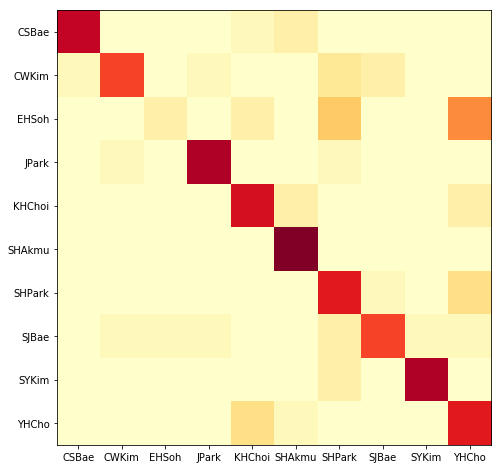

In [93]:
plt.imshow(cm.T, interpolation='nearest', cmap='YlOrRd')
plt.xticks(np.arange(0, len(idx_to_genre)), idx_to_genre)
plt.yticks(np.arange(0, len(idx_to_genre)), idx_to_genre)

plt.show()

In [94]:
m1 = cnn_melspect_1D_org((128, 128))
m2 = cnn_melspect_1D((128, 128))
ac1 = 0.61 * 5
ac2 = 0
for i in range(5):
    history = m1.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=1,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac1 += history.history['val_acc'][-1]
    history = m2.fit(x_train, y_train,
      batch_size=128,
      epochs=100,
      verbose=0,
      validation_data=(x_test, y_test),
      callbacks = [earlystop])
    ac2 += history.history['val_acc'][-1]

print(ac1 / 5, ac2 / 5)

NameError: name 'cnn_melspect_1D_org' is not defined